# 1. loading data and overview

## 1.1. libraries

In [32]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.layers import Dense
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.svm import SVC
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.sparse as sp
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")


## 1.2. loading data

In [3]:
## caminho pro Google Drive
# drive.mount('/content/drive', force_remount=True)
# file = '/content/drive/MyDrive/Le Wagon/filtered_columns_LLCP2023.csv'

## caminhi pro data local
file = 'filtered_columns_LLCP2023.csv'
df   = pd.read_csv(file)

## DataFrame shape
print(df.shape)

(163435, 38)


In [4]:
df['_RFCHOL3'].value_counts()

,count
_RFCHOL3,
1.0,81200
2.0,61389
9.0,1230


In [5]:
df.columns

Index(['_PACAT3', '_RFHYPE6', '_RFCHOL3', '_MICHD', '_LTASTH1', '_AGEG5YR',
       '_DRDXAR2', 'HTM4', 'WTKG3', '_BMI5CAT', '_EDUCAG', '_INCOMG1',
       '_PAINDX3', 'SEXVAR', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'CHECKUP1',
       'EXERANY2', 'EXRACT12', 'EXERHMM1', 'EXRACT22', 'CVDINFR4', 'CVDCRHD4',
       'CVDSTRK3', 'CHCOCNC1', 'CHCCOPD3', 'ADDEPEV3', 'CHCKDNY2', 'DIABETE4',
       'DECIDE', 'DIFFALON', '_PHYS14D', '_MENT14D', 'MAXVO21_', 'ACTIN13_',
       'STRFREQ_', 'PA3MIN_'],
      dtype='object')

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

## 1.3 functions

In [7]:
def compress(df, **kwargs):
    """
    Reduces the size of the DataFrame by downcasting numerical columns
    """
    input_size = df.memory_usage(index=True).sum()/ 1024**2
    print("old dataframe size: ", round(input_size,2), 'MB')

    in_size = df.memory_usage(index=True).sum()

    for t in ["float", "integer"]:
        l_cols = list(df.select_dtypes(include=t))

        for col in l_cols:
            df[col] = pd.to_numeric(df[col], downcast=t)

    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100

    print("optimized size by {} %".format(round(ratio,2)))
    print("new DataFrame size: ", round(out_size / 1024**2,2), " MB")

    return df

In [8]:
df = compress(df, verbose=True)
df.head(1)

old dataframe size:  47.38 MB
optimized size by 50.0 %
new DataFrame size:  23.69  MB


,_PACAT3,_RFHYPE6,_RFCHOL3,_MICHD,_LTASTH1,_AGEG5YR,_DRDXAR2,HTM4,WTKG3,_BMI5CAT,_EDUCAG,_INCOMG1,_PAINDX3,SEXVAR,GENHLTH,PHYSHLTH,MENTHLTH,CHECKUP1,EXERANY2,EXRACT12,EXERHMM1,EXRACT22,CVDINFR4,CVDCRHD4,CVDSTRK3,CHCOCNC1,CHCCOPD3,ADDEPEV3,CHCKDNY2,DIABETE4,DECIDE,DIFFALON,_PHYS14D,_MENT14D,MAXVO21_,ACTIN13_,STRFREQ_,PA3MIN_
0,4.00,2.00,1.00,2.00,1.00,13.00,2.00,160.00,78.02,4.00,3.00,9.00,2.00,2.00,2.00,88.00,88.00,2.00,2.00,NaN,NaN,NaN,2.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,2.00,2.00,1.00,1.00,1840.00,NaN,0.00,NaN


In [9]:
df.dtypes

,0
_PACAT3,float32
_RFHYPE6,float32
_RFCHOL3,float32
_MICHD,float32
_LTASTH1,float32
_AGEG5YR,float32
_DRDXAR2,float32
HTM4,float32
WTKG3,float32
_BMI5CAT,float32


# 2. null values

In [10]:
## overview - missing values
missing_values        = df.isnull().sum()
missing_values_sorted = missing_values.sort_values(ascending=False)
print(missing_values_sorted.head(20))

PA3MIN_     46253
ACTIN13_    43573
EXERHMM1    41422
EXRACT22    41422
EXRACT12    40620
_RFCHOL3    19616
_BMI5CAT    15119
WTKG3       12676
HTM4         8414
DIFFALON     6901
DECIDE       5832
STRFREQ_     5163
_MICHD       1806
_DRDXAR2      929
DIABETE4        3
PHYSHLTH        2
MENTHLTH        2
GENHLTH         2
EXERANY2        2
CVDINFR4        2
dtype: int64


# 3. categorical and numerical variables

## 3.1. categorical variables

Código abaixo trata as variáveis categóricas e substitui os valores por nan, de acordo com as peculiaridades de cada coluna que foram examinadas

In [11]:
## categorical variables
categorical_col = ['_PACAT3', '_RFHYPE6', '_RFCHOL3', '_MICHD', '_LTASTH1',
                   '_AGEG5YR', '_DRDXAR2', '_BMI5CAT', '_EDUCAG', '_INCOMG1',
                   'SEXVAR', 'GENHLTH', 'EXERANY2', 'CHECKUP1', 'EXRACT12',
                   'EXRACT22', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'CHCOCNC1',
                   'CHCCOPD3', 'ADDEPEV3', 'CHCKDNY2', 'DIABETE4',
                   'DECIDE', 'DIFFALON', '_PHYS14D', '_MENT14D', 'ACTIN13_', '_PAINDX3'
                  ]

## replacing 88 to zero and the others to NaN
df[categorical_col] = df[categorical_col].replace(88.0, 0)
df[categorical_col] = df[categorical_col].replace([77.0, 777.0, 7777.0, 888.0, 99.0, 999.0], np.nan)

#_PACAT3, _INCOMG1, _PAINDX3  NAO tiramos o 9 para nao criar noise!!!!!!!!!!
## 9 = refused (ref)
cat_col_ref = ["_RFCHOL3", "_LTASTH1", "GENHLTH", "EXERANY2",
               "CHECKUP1", "CVDINFR4", "CVDCRHD4", "CVDSTRK3", "CHCOCNC1", "CHCCOPD3",
               "ADDEPEV3", "CHCKDNY2", "DIABETE4", "DECIDE", "DIFFALON", "_PHYS14D",
               "_MENT14D", "_RFHYPE6", "_EDUCAG"]
df[cat_col_ref] = df[cat_col_ref].replace(9.0, np.nan)


## 7 = don't know (dk)
cat_col_dk     = ["GENHLTH", "DIABETE4", "EXERANY2", "CHECKUP1", "CVDINFR4", "CVDSTRK3", "CHCOCNC1", "CHCCOPD3", "ADDEPEV3", "CHCKDNY2", "DECIDE", "DIFFALON"]
df[cat_col_dk] = df[cat_col_dk].replace(7.0, np.nan)

## 3.2. numerical variables

In [12]:
## selecting numeric columns
numerical_cols  = df.drop(columns=categorical_col)

## columns where 77/88/888/999 should NOT be NaN (part of the dataset - manually verified (vrf))
num_col_not_nan = ["HTM4", "WTKG3", "EXERHMM1", "MAXVO21_", "STRFREQ_", "PA3MIN_"]

## filtering numeric columns where 77/88/888 should be NaN
num_col_nan = numerical_cols.drop(columns=num_col_not_nan)

## replacing 88 to zero and the others to NaN
df[num_col_nan.columns] = df[num_col_nan.columns].replace(88.0, 0)
df[num_col_nan.columns] = df[num_col_nan.columns].replace([77.0, 777.0, 7777.0, 888.0, 99.0, 999.0], np.nan)

## 99900.0 = NaN
df[["MAXVO21_", "STRFREQ_"]] = df[["MAXVO21_", "STRFREQ_"]].replace([99900.0], np.nan)

In [13]:
df.head()

,_PACAT3,_RFHYPE6,_RFCHOL3,_MICHD,_LTASTH1,_AGEG5YR,_DRDXAR2,HTM4,WTKG3,_BMI5CAT,_EDUCAG,_INCOMG1,_PAINDX3,SEXVAR,GENHLTH,PHYSHLTH,MENTHLTH,CHECKUP1,EXERANY2,EXRACT12,EXERHMM1,EXRACT22,CVDINFR4,CVDCRHD4,CVDSTRK3,CHCOCNC1,CHCCOPD3,ADDEPEV3,CHCKDNY2,DIABETE4,DECIDE,DIFFALON,_PHYS14D,_MENT14D,MAXVO21_,ACTIN13_,STRFREQ_,PA3MIN_
0,4.00,2.00,1.00,2.00,1.00,13.00,2.00,160.00,78.02,4.00,3.00,9.00,2.00,2.00,2.00,0.00,0.00,2.00,2.00,NaN,NaN,NaN,2.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,2.00,2.00,1.00,1.00,1840.00,NaN,0.00,NaN
1,1.00,2.00,2.00,2.00,1.00,13.00,1.00,145.00,59.87,3.00,3.00,9.00,1.00,2.00,2.00,0.00,0.00,2.00,1.00,1.00,30.00,0.00,2.00,2.00,2.00,2.00,2.00,1.00,2.00,3.00,2.00,2.00,1.00,1.00,1803.00,2.00,0.00,360.00
2,9.00,2.00,2.00,2.00,2.00,13.00,1.00,163.00,58.97,2.00,2.00,1.00,9.00,2.00,4.00,6.00,2.00,1.00,1.00,1.00,15.00,0.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,3.00,1.00,2.00,2.00,2.00,1322.00,2.00,1167.00,36.00
3,9.00,1.00,1.00,2.00,1.00,12.00,1.00,168.00,77.11,3.00,3.00,9.00,1.00,2.00,2.00,2.00,0.00,3.00,1.00,1.00,30.00,0.00,2.00,2.00,2.00,1.00,2.00,1.00,2.00,3.00,2.00,2.00,2.00,1.00,1914.00,2.00,0.00,180.00
4,1.00,2.00,1.00,2.00,1.00,12.00,1.00,173.00,77.11,3.00,3.00,5.00,1.00,2.00,4.00,0.00,0.00,1.00,1.00,1.00,45.00,8.00,2.00,2.00,2.00,1.00,2.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1988.00,2.00,0.00,600.00


## 3.3. other features treatment

In [14]:
## copy
df_transformed = df.copy()

## alterando 1=yes, 2=no
mapeamento_RFCHOL3  = {1:2, 2:1}
mapeamento_LTASTH1  = {1:2, 2:1}
mapeamento_DIABETE4 = {1:1, 2:1, 3:2, 4:2} # gravidas... viraram yes

# Aplicando o mapeamento
df_transformed['_RFCHOL3'] = df_transformed['_RFCHOL3'].map(mapeamento_RFCHOL3)
df_transformed['_LTASTH1'] = df_transformed['_LTASTH1'].map(mapeamento_LTASTH1)
df_transformed['DIABETE4'] = df_transformed['DIABETE4'].map(mapeamento_DIABETE4)

# 4. encoding

## 5.1. categorical columns

In [15]:
## Definir as categorias específicas para cada variável ordinal
ordinal_cols = ['_PACAT3', '_AGEG5YR', '_BMI5CAT', '_EDUCAG', '_INCOMG1',
                'CHECKUP1', '_PHYS14D', '_MENT14D'] # GENHLTH é o target -> não passa por transformações

categories = [
    [1, 2, 3, 4, 9],                                  # _PACAT3 (Highly Active, Active, Insufficiently Active, Inactive)
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],  # _AGEG5YR (age groups from 1 to 14)
    [1, 2, 3, 4],                                     # _BMI5CAT (underweight, normal, overweight, obese)
    [1, 2, 3, 4],                                     # _EDUCAG (education levels)
    [1, 2, 3, 4, 5, 6, 7, 8, 9],                      # _INCOMG1 (income groups from 1 to 8)
    # [1, 2, 3, 4, 5],                                  # GENHLTH (health levels from Excellent to Poor) --> retirado, pois não tem encoding nela
    [1, 2, 3, 4, 7, 8, 9],                            # CHECKUP1 (time since last checkup)
    [1, 2, 3],                                        # _PHYS14D (0 days, 1-13 days, 14-30 days)
    [1, 2, 3]                                         # _MENT14D (0 days, 1-13 days, 14-30 days)
]

## Definir as colunas nominais (sem ordem)
drop_cols    = ordinal_cols + numerical_cols.columns.tolist()
nominal_cols = df_transformed.drop(columns=drop_cols)
nominal_cols = nominal_cols.drop(columns="GENHLTH").columns

# 5. pipeline das variaveis

In [16]:
## numerical variables
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                        ('scaler',  StandardScaler())  # Normalização de colunas numéricas
                                       ])

## categorical variables
# ordinal
ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),  # Imputação de valores ausentes
                                      ('ord_encoder', OrdinalEncoder(categories=categories)) # Aplicação do OrdinalEncoder
                                     ])

# nominals
nominal_transformer = Pipeline(steps=[('imputer',        SimpleImputer(strategy='most_frequent')),  # Imputação de valores ausentes
                                      ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'))    # Aplicação do OneHotEncoder
                                     ])


## ColumnTransformer for all variables
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_cols.columns),
                                               ('ord', ordinal_transformer,   df_transformed[ordinal_cols].columns),
                                               ('nom', nominal_transformer,   nominal_cols)
                                              ]
                                )

# 6. EDA

### 7.1.1. target distribution

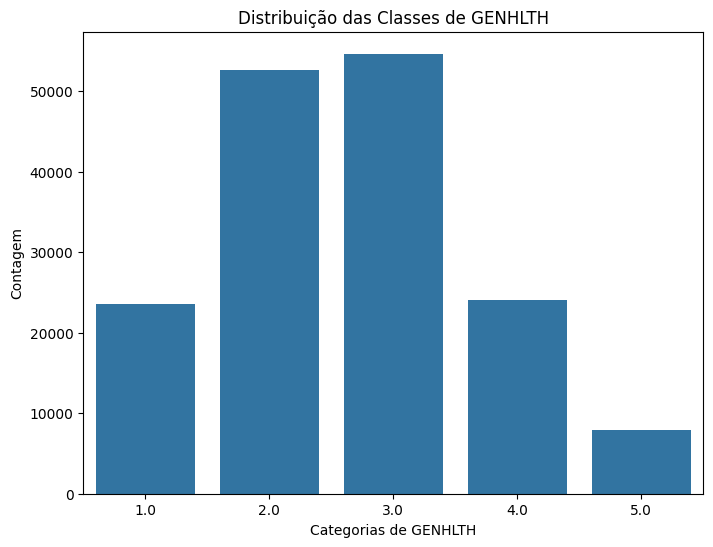

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='GENHLTH', data=df)
plt.title('Distribuição das Classes de GENHLTH')
plt.xlabel('Categorias de GENHLTH')
plt.ylabel('Contagem')
plt.show()

### 7.1.2. histograms

In [ ]:
# Iterar sobre cada coluna do dataframe
for num_col in numerical_col.columns:
    plt.figure(figsize=(10, 6))

    # Plotar histograma para a coluna atual
    plt.hist(df_imputed[num_col].dropna(), bins=30, edgecolor='k')

    # Adicionar título e labels
    plt.title(f'Distribuição da variável: {num_col}')
    plt.xlabel(num_col)
    plt.ylabel('Frequência')

    # Mostrar o gráfico
    plt.show()

NameError: name 'numerical_col' is not defined

### 7.1.2. boxplot

In [ ]:
for num_col in numerical_col.columns:
    plt.figure(figsize=(10, 6))

    # Plotar boxplot para a coluna atual
    plt.boxplot(df_imputed[num_col].dropna(), vert=False, patch_artist=True)

    # Adicionar título e labels
    plt.title(f'Boxplot da variável: {num_col}')
    plt.xlabel(num_col)

    # Mostrar o gráfico
    plt.show()

### 7.1.3. barplot


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

for i in categorical_col:
        plt.figure(figsize=(7, 3))

        counts = df[i].value_counts()
        plt.bar(counts.index, counts.values, color='skyblue')
        plt.xlabel(i)
        plt.ylabel('Frequência')
        plt.title(f'Barplot da Coluna: {i}')
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.show()

### 7.1.4. scatterplot

In [ ]:
# Supondo que df seja o seu DataFrame
target = 'GENHLTH'

# Criar scatterplots para todas as variáveis (menos o target)
for column in df_scaled.columns:
    if column != target:  # Excluir o target
        plt.figure(figsize=(6, 4))
        plt.scatter(df_scaled[column], df_imputed[target], alpha=0.5)
        plt.title(f'Scatterplot: {column} vs {target}')
        plt.xlabel(column)
        plt.ylabel(target)
        plt.show()

### 7.1.5. correlation

In [ ]:
correlations = df_imputed.corr()['GENHLTH'].sort_values(ascending=False)
print(correlations)

In [ ]:
df_imputed.columns

# 7. target

## 7.1. target distribution

### 7.1.1. original data

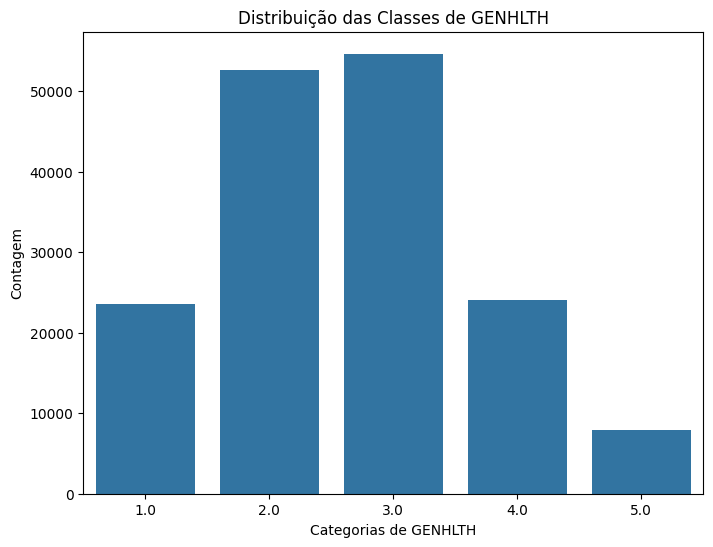

In [19]:
plt.figure(figsize=(8, 6))
sns.countplot(x='GENHLTH', data=df)
plt.title('Distribuição das Classes de GENHLTH')
plt.xlabel('Categorias de GENHLTH')
plt.ylabel('Contagem')
plt.show()

### 7.1.2. only 3 categories

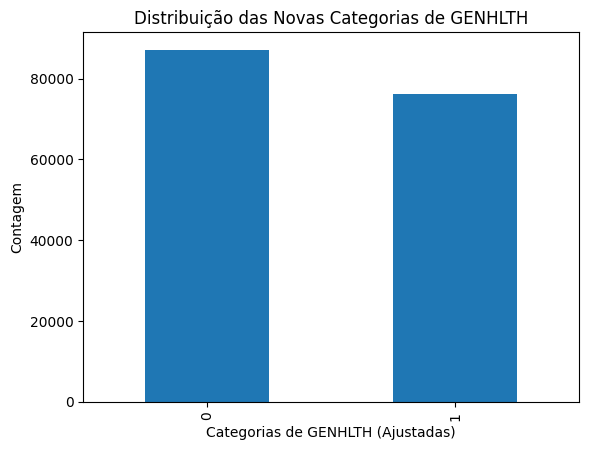

In [20]:
def label_engineering(genhlth):
    if genhlth in [1, 2]:
        return 0
    elif genhlth in [4, 5]:
        return 2  # Combina Fair e Poor
    else:
      return 1

# Aplicando a função no target 'GENHLTH'
df_transformed['GENHLTH'] = df_transformed['GENHLTH'].apply(label_engineering)
df_transformed['GENHLTH'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Categorias de GENHLTH (Ajustadas)")
plt.ylabel("Contagem")
plt.title("Distribuição das Novas Categorias de GENHLTH")
plt.show()

In [21]:
df_transformed['GENHLTH'].value_counts()

,count
GENHLTH,
0,87125
1,76310


In [22]:
## features, target
X = df_transformed.drop(columns=['GENHLTH'])
y = df_transformed['GENHLTH']

In [23]:
df_transformed.shape

(163435, 38)

In [24]:
y

,GENHLTH
0,1
1,1
2,0
3,1
4,0
...,...
163430,1
163431,0
163432,1
163433,0


In [25]:
y.shape

(163435,)

# 8. modelling

## 8.2 XGBoost

### 8.2.1. checking best paramns and estimators (RandomSearch)

In [29]:
## splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## params
param_dist = {
    'classifier__max_depth':        [3, 5],
    'classifier__learning_rate':    [0.1],
    'classifier__n_estimators':     [50, 100],
    'classifier__colsample_bytree': [0.7],
    'classifier__subsample':        [0.8],
    'classifier__gamma':            [0, 0.1],
    'classifier__min_child_weight': [1, 5]
}

## model
xgb_model = XGBClassifier(random_state=42)

## pipeline (preprocessing and model)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier',   xgb_model)
                          ]
                   )


## random search
random_search = RandomizedSearchCV(estimator=pipeline,
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   scoring='f1_weighted',
                                   cv=2,
                                   n_jobs=-1,
                                   random_state=42,
                                   verbose=2
                                  )

random_search.fit(X_train, y_train)


## best hiperparams
print("Melhores hiperparâmetros:", random_search.best_params_)

## best estimators
best_xgb = random_search.best_estimator_
print("best estimators:         ", best_xgb)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Melhores hiperparâmetros: {'classifier__subsample': 0.8, 'classifier__n_estimators': 100, 'classifier__min_child_weight': 5, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.7}
best estimators:          Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['HTM4', 'WTKG3', 'PHYSHLTH', 'MENTHLTH', 'EXERHMM1', 'MAXVO21_',
       'STRFREQ_', 'PA3MIN_'],
      dtype='object')),
                                                 ('ord',
           

### 8.2.2. modelling with the best params

In [30]:
## fit
best_xgb.fit(X_train, y_train)

## predict
y_pred_best = best_xgb.predict(X_test)

## confusion matrix
print("Confusion Matrix:\n       ", confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))



Confusion Matrix:
        [[19031  7132]
 [ 6149 16719]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.73      0.74     26163
           1       0.70      0.73      0.72     22868

    accuracy                           0.73     49031
   macro avg       0.73      0.73      0.73     49031
weighted avg       0.73      0.73      0.73     49031


Accuracy com os melhores hiperparâmetros: 0.73


### 8.2.3. evaluating metrics

In [35]:
## metrics
mse  = mean_squared_error(y_test, y_pred_best)
r2   = r2_score(y_test, y_pred_best)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred_best)


## other metrics
accuracy  = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best)
recall    = recall_score(y_test, y_pred_best)
f1        = f1_score(y_test, y_pred_best)


print(f"MSE:       {mse}")
print(f"R²:        {r2}")
print(f"MAE:       {mae}")
print(f"RMSE:      {rmse}")
print(f"Accuracy:  {accuracy}")
print(f"Precision: {precision}")
print(f"Recall:    {recall}")
print(f"F1:        {f1}")

MSE:       0.270869449939834
R²:        -0.08839315758565869
MAE:       0.270869449939834
RMSE:      0.5204511984229011
Accuracy:  0.729130550060166
Precision: 0.7009768982432603
Recall:    0.7311089732377121
F1:        0.7157259359147242


# 9. saving model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pickle

# Salvando o modelo treinado
with open('best_xgb_model.pkl', 'wb') as file:
    pickle.dump(best_xgb, file)

Mounted at /content/drive


# 10. other models (only tests - no need to run it)

## 10.1. logistic regression

In [37]:
## splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## model and fitting
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

## predicting
y_pred = log_reg.predict(X)

## score
log_reg.score(X_test, y_test)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## 10.2. Artificial Neural Networks (ANN)


In [ ]:
## splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## model
ann = Sequential()

# Camada de entrada e primeira camada oculta (com 64 neurônios e função de ativação ReLU)
ann.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))

# Segunda camada oculta
ann.add(Dense(32, activation='relu'))

# Camada de saída (5 neurônios para as 5 classes, usando softmax para classificação multiclasse)
ann.add(Dense(5, activation='softmax'))

## compiling
ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## score
mn_nb.score(X_test, y_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


0.5713711500778778

## 10.3. SVM

In [ ]:
## splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## model
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

## prediction
y_pred = svm.predict(X_test)

## score
svm.score(X_test, y_test)

## 10.4. KNN

In [ ]:
## splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

## prediction
y_pred = knn.predict(X_test)

## score
knn.score(X_test, y_test)

## 10.5 RandomForestClassifier

In [ ]:
# Importações necessárias
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Dividindo o dataset em treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instanciando o RandomForestClassifier
model_rf = RandomForestClassifier(random_state=42)

# Treinando o modelo nos dados de treino
model_rf.fit(X_train, y_train)

# Fazendo previsões nos dados de teste
y_pred_rf = model_rf.predict(X_test)

# Avaliando o modelo
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Métricas adicionais, como acurácia:
accuracy_rf = model_rf.score(X_test, y_test)
print(f"\nAccuracy: {accuracy_rf:.2f}")

In [ ]:
! pip freeze

## 10.6. Gaussian naive bayes

In [ ]:
## splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## model
mn_nb = GaussianNB()
mn_nb.fit(X_train, y_train)

## prediction
y_pred = mn_nb.predict(X_test)

## score
mn_nb.score(X_test, y_test)

0.5713711500778778